<a href="https://colab.research.google.com/github/owen198/csc_domain_adaptation/blob/main/csc_lstm_ae(W4662FM0605_W4662FM0507).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Modules

In [1]:
# https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import mean_squared_error

import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random

from keras import metrics
from keras import Model
from keras import models
from keras import utils
from keras import losses
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Input, BatchNormalization, Activation
from keras.callbacks import EarlyStopping

# Parameters

In [2]:
timesteps = 16
n_features = 390
retrain = True

# Load Data and proprecessing

### Load data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
tag_dict = {'source':'W4662FM0605',
            'source_training_from': datetime.datetime(2020,3,1,0,0),
            'source_training_to': datetime.datetime(2020,4,1,0,0),
            'source_end': datetime.datetime(2020,7,1,0,0),
            
            'target':'W4662FM0606',
            'target_training_from': datetime.datetime(2020,9,1,0,0), 
            'target_training_to': datetime.datetime(2021,1,1,0,0), 
            'target_end': datetime.datetime(2021,2,1,0,0)}

path = './gdrive/MyDrive/data/CSC/W4/'

In [5]:

globals()[tag_dict['target']] = pd.concat([pd.read_csv(path + tag_dict['target'] + '_202009.csv'),
                                          pd.read_csv(path + tag_dict['target'] + '_202010.csv'),
                                          pd.read_csv(path + tag_dict['target'] + '_202011.csv'),
                                          pd.read_csv(path + tag_dict['target'] + '_202012.csv'),
                                          pd.read_csv(path + tag_dict['target'] + '_202101.csv'),
                                          pd.read_csv(path + tag_dict['target'] + '_202102.csv')])

globals()[tag_dict['source']] = pd.concat([pd.read_csv(path + tag_dict['source'] + '_202003.csv'),
                                          pd.read_csv(path + tag_dict['source'] + '_202004.csv'),
                                          pd.read_csv(path + tag_dict['source'] + '_202005.csv'),
                                          pd.read_csv(path + tag_dict['source'] + '_202006.csv'),
                                          pd.read_csv(path + tag_dict['source'] + '_202007.csv')])

### Process Data

In [6]:
globals()[tag_dict['source']]['datetime'] = globals()[tag_dict['source']]['timestamp'].astype('int').astype("datetime64[s]")
globals()[tag_dict['target']]['datetime'] = globals()[tag_dict['target']]['timestamp'].astype('int').astype("datetime64[s]")

In [7]:
globals()[tag_dict['source']+'_training'] = globals()[tag_dict['source']][
                                                  (globals()[tag_dict['source']]['datetime'] > tag_dict['source_training_from']) &
                                                  (globals()[tag_dict['source']]['datetime'] <= tag_dict['source_training_to']) ]

globals()[tag_dict['target']+'_training'] = globals()[tag_dict['target']][
                                                  (globals()[tag_dict['target']]['datetime'] > tag_dict['target_training_from']) &
                                                  (globals()[tag_dict['target']]['datetime'] <= tag_dict['target_end']) ]

In [8]:
drop_list = ['Unnamed: 0', '_id','type','scada','timestamp','device', 'datetime']

globals()[tag_dict['source']+'_training'] = globals()[tag_dict['source']+'_training'].drop(columns=drop_list)
globals()[tag_dict['target']+'_training'] = globals()[tag_dict['target']+'_training'].drop(columns=drop_list)

In [9]:
shape_min = min (globals()[tag_dict['source']+'_training'].shape[0], 
                 globals()[tag_dict['target']+'_training'].shape[0])
shape_max = max (globals()[tag_dict['source']+'_training'].shape[0], 
                 globals()[tag_dict['target']+'_training'].shape[0])

index = sorted(random.sample(range(0, shape_max), shape_min))

In [10]:
normalizer = preprocessing.MinMaxScaler()
source_normalizer = normalizer.fit(globals()[tag_dict['source']+'_training'])

normalizer = preprocessing.MinMaxScaler()
target_normalizer = normalizer.fit(globals()[tag_dict['target']+'_training'])

X_source = pd.DataFrame(source_normalizer.transform(globals()[tag_dict['source']+'_training']))
X_target = pd.DataFrame(source_normalizer.transform(globals()[tag_dict['target']+'_training']))

In [11]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []

    for i in range(X.shape[0]-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [12]:
if len(X_target) > len(X_source):
    X = X_target.iloc[index]
    Y = X_source
else:
    X = X_target
    Y = X_source.iloc[index]

#X, y = temporalize(X = timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)
X, _ = temporalize(X = X.values, y = np.zeros(len(X)), lookback = timesteps)
Y, _ = temporalize(X = Y.values, y = np.zeros(len(Y)), lookback = timesteps)

X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)

Y = np.array(Y)
Y = Y.reshape(np.array(Y).shape[0], timesteps, n_features)

# LSTM-AE Model

In [13]:
def lstm_ae():
    # define model
    model = Sequential(name='test')
    model.add(LSTM(64, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
    model.add(LSTM(16, activation='relu', return_sequences=False))
    model.add(RepeatVector(timesteps))
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer='adam', loss='mse', metrics=[metrics.RootMeanSquaredError()])
    model.summary()

    return model

In [14]:
model_name = './gdrive/My Drive/data/CSC/W4/' + tag_dict['target'] + '_encoded'
model_name

if retrain:

    encoder = Sequential(
        [
            LSTM(64, activation='relu', return_sequences=True),
            LSTM(16, activation='relu', return_sequences=False),
            RepeatVector(timesteps)
        ],
        name='encoder'
    )

    decoder = Sequential(
        [
            LSTM(16, activation='relu', return_sequences=True),
            LSTM(64, activation='relu', return_sequences=True),
            TimeDistributed(Dense(n_features))
        ],
        name='decoder'
    )

    source = Input(shape=(timesteps,n_features), name='source')
    target = Input(shape=(timesteps,n_features), name='target')
    synthetic = decoder(encoder(source))


    model = Model(
        inputs={'source': source, 'target': target},
        outputs=synthetic
    )

    transformation_loss = losses.mean_squared_error(target, synthetic)
    model.add_loss(transformation_loss)
    model.add_metric(transformation_loss, name='transformation_loss')

    model.compile(optimizer='adam', metrics=[metrics.RootMeanSquaredError()])
    model.summary()

    lstm_ae_model = model.fit(
                        x={'source': Y, 'target': X},
                        epochs=20,
                        batch_size=16, 
                        verbose=1,
                        validation_split=0.2
    )

    model.save(model_name)

else:
    model = models.load_model(model_name)  

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
source (InputLayer)             [(None, 16, 390)]    0                                            
__________________________________________________________________________________________________
encoder (Sequential)            (None, 16, 16)       121664      source[0][0]                     
__________________________________________________________________________________________________
target (InputLayer)             [(None, 16, 390)]    0                                            
__________________________________________________________________________________________________
decoder (Sequential)            (None, 16, 390)      48198       encoder[0][0]                    
______________________________________________________________________________________________

In [15]:
model_name = './gdrive/My Drive/data/CSC/W4/' + tag_dict['target'] + '_encoded'
model_name

'./gdrive/My Drive/data/CSC/W4/W4662FM0606_encoded'

In [16]:
# if retrain:
#     early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=2)

#     model = lstm_ae ()
#     lstm_ae_model = model.fit(x=Y, 
#                               y=X, 
#                               epochs=10, batch_size=16, verbose=1, validation_split=0.2, callbacks=[early_stopping])
#     model.save(model_name)
# else:
#     model = models.load_model(model_name)  
    

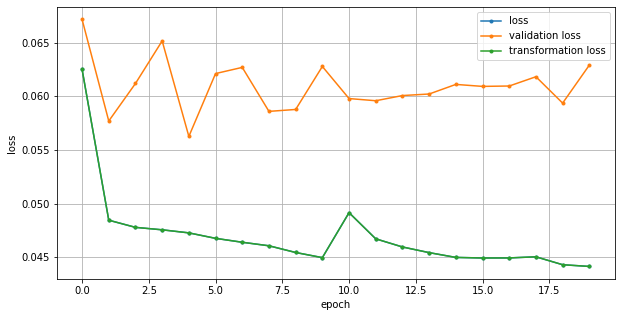

In [17]:
if retrain:
    fig, ax = plt.subplots(figsize=(10,5))

    ax.plot(lstm_ae_model.history['loss'], marker='.', label='loss')
    ax.plot(lstm_ae_model.history['val_loss'], marker='.', label='validation loss')
    ax.plot(lstm_ae_model.history['transformation_loss'], marker='.', label='transformation loss')

    ax.legend()
    ax.grid(True)

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig('epoches.png', dpi=300)
    plt.show()

# Validation

### Initial functions

In [18]:
synthetic_data = model.predict(x={'source': Y, 'target': X}, verbose=0)
synthetic_pd = pd.DataFrame.from_records([i[0] for i in synthetic_data])

In [19]:
def scorer_(Y_pred):
    a = (Y_pred[Y_pred == -1].size)/(Y_pred.size)
    return a*100

In [20]:
def plot_score (score_list, date_list, tag):

    fig, ax = plt.subplots(figsize=(10, 3))
    plt.xticks(rotation=45)
    ax.plot(date_list, score_list, '.-')
    ax.set(xlabel='date', ylabel='score', title=tag)
    ax.grid()
    plt.ylim(0, 100)
    plt.tight_layout()
    #fig.savefig(path+tag+'-'+training_from.strftime("%Y%m%d")+'-'+training_to.strftime("%Y%m%d")+'.png', dpi=300)
    plt.show()

In [21]:
def get_score (data_df, start_date, end_date, normalizer, prediction_model):

    score_list = []
    date_list = []
    delta = datetime.timedelta(days=1)

    while start_date <= end_date:

        validation_df = data_df[(data_df['datetime'] > start_date) & 
                                (data_df['datetime'] <= start_date + delta)]

        print(validation_df.shape, start_date)

        
        if validation_df.shape[0] > 0:

            validation_df_score = validation_df.drop(columns=drop_list)
            validation_df_score = normalizer.transform(validation_df_score)
            validation_df_score = prediction_model.predict(validation_df_score)

            score_list.append(scorer_(validation_df_score))
            date_list.append(start_date)

        start_date += delta
        
    return score_list, date_list

In [22]:
model_source = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(X_source)
model_target = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(X_target)
model_synthetic = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(synthetic_pd)

## Detecting synthetic data by target model

In [23]:
source_test_pd = pd.DataFrame()
source_test_pd = globals()[tag_dict['source']]
source_test_pd = source_test_pd.drop(columns=drop_list)

index_2 = sorted(random.sample(range(0, source_test_pd.shape[0]), shape_min))

source_test_pd = pd.DataFrame(source_normalizer.transform(source_test_pd)).iloc[index_2]

source_test_np, _ = temporalize(X = source_test_pd.values, 
                                y = np.zeros(source_test_pd.shape[0]), 
                                lookback = timesteps)

source_test_np = np.array(source_test_np)
source_test_np = source_test_np.reshape(source_test_np.shape[0], timesteps, n_features)

synthetic_source = model.predict(x={'source': source_test_np, 'target': X}, verbose=0)
synthetic_source_pd = pd.DataFrame.from_records([i[0] for i in synthetic_source])

In [24]:
#diff = globals()[tag_dict['source']].shape[0] - synthetic_source_pd.shape[0]
#len = globals()[tag_dict['source']].shape[0] - diff

for elements in drop_list:
    synthetic_source_pd[elements] = globals()[tag_dict['source']][elements].iloc[index_2].tail(13265).values

In [25]:
synthetic_source_pd.shape

(13265, 397)

In [26]:
def get_syntheic_score (data_df, start_date, end_date, prediction_model):

    score_list = []
    date_list = []
    delta = datetime.timedelta(days=1)

    while start_date <= end_date:

        validation_df = data_df[(data_df['datetime'] > start_date) & 
                                (data_df['datetime'] <= start_date + delta)]

        if validation_df.shape[0] > 0:

            validation_df_score = validation_df.drop(columns=drop_list)
            validation_df_score = prediction_model.predict(validation_df_score)

            score_list.append(scorer_(validation_df_score))
            date_list.append(start_date)

            print(validation_df.shape, start_date, scorer_(validation_df_score))

        start_date += delta
        
    return score_list, date_list

In [27]:
synthetic_score, synthetic_date = get_syntheic_score(synthetic_source_pd, 
                                            tag_dict['source_training_from'], 
                                            tag_dict['source_end'], 
                                            model_target)

source_score_cv, source_date_cv = get_score(globals()[tag_dict['source']], 
                                            tag_dict['source_training_from'], 
                                            tag_dict['source_end'], 
                                            source_normalizer,
                                            model_target)

source_score, source_date = get_score(globals()[tag_dict['source']], 
                                            tag_dict['source_training_from'], 
                                            tag_dict['source_end'], 
                                            source_normalizer,
                                            model_source)

(92, 397) 2020-03-01 00:00:00 0.0
(36, 397) 2020-03-02 00:00:00 0.0
(107, 397) 2020-03-03 00:00:00 0.0
(9, 397) 2020-03-04 00:00:00 0.0
(129, 397) 2020-03-05 00:00:00 0.0
(122, 397) 2020-03-06 00:00:00 0.0
(132, 397) 2020-03-07 00:00:00 0.0
(132, 397) 2020-03-08 00:00:00 0.0
(83, 397) 2020-03-09 00:00:00 0.0
(98, 397) 2020-03-10 00:00:00 0.0
(113, 397) 2020-03-11 00:00:00 0.0
(76, 397) 2020-03-12 00:00:00 0.0
(166, 397) 2020-03-13 00:00:00 0.0
(123, 397) 2020-03-14 00:00:00 0.0
(131, 397) 2020-03-15 00:00:00 0.0
(92, 397) 2020-03-16 00:00:00 0.0
(93, 397) 2020-03-17 00:00:00 0.0
(36, 397) 2020-03-18 00:00:00 0.0
(23, 397) 2020-03-19 00:00:00 0.0
(126, 397) 2020-03-20 00:00:00 0.0
(77, 397) 2020-03-21 00:00:00 0.0
(98, 397) 2020-03-22 00:00:00 0.0
(98, 397) 2020-03-23 00:00:00 0.0
(128, 397) 2020-03-24 00:00:00 0.0
(30, 397) 2020-03-25 00:00:00 0.0
(80, 397) 2020-03-27 00:00:00 0.0
(112, 397) 2020-03-28 00:00:00 0.0
(127, 397) 2020-03-29 00:00:00 0.0
(108, 397) 2020-03-30 00:00:00 0.0
(

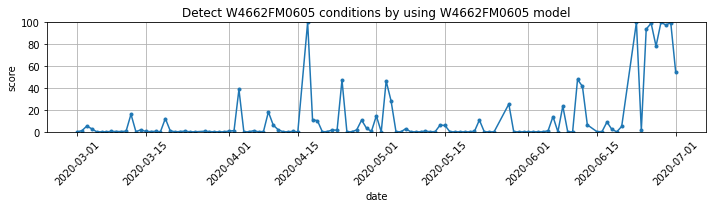

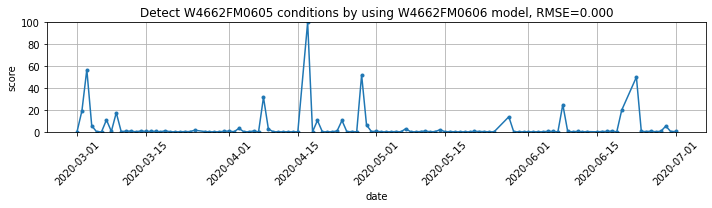

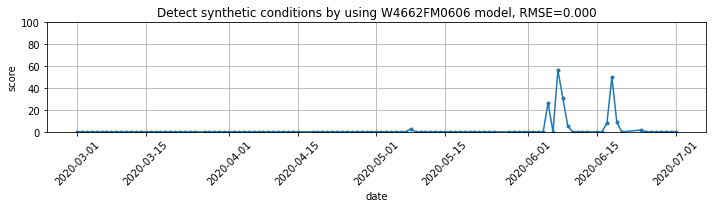

In [28]:
sy_rmse = 0
cv_rmse = 0
plot_score (source_score, 
            source_date, 
            'Detect ' + tag_dict['source'] +' conditions by using '+ tag_dict['source'] +' model')

plot_score (source_score_cv, 
            source_date_cv, 
            'Detect ' + tag_dict['source'] +' conditions by using '+ tag_dict['target'] +' model, RMSE='+ "{:.3f}".format(cv_rmse))

plot_score (synthetic_score, 
            synthetic_date, 
            'Detect synthetic conditions by using '+ tag_dict['target'] +' model, RMSE='+ "{:.3f}".format(sy_rmse))

## Detecting by synthetic

In [29]:
target_score_cv, target_date_cv = get_score(globals()[tag_dict['target']], 
                                            tag_dict['target_training_from'], 
                                            tag_dict['target_end'], 
                                            source_normalizer,
                                            model_source)

target_score, target_date = get_score(globals()[tag_dict['target']], 
                                            tag_dict['target_training_from'], 
                                            tag_dict['target_end'], 
                                            source_normalizer,
                                            model_target)

target_score_da, target_date_da = get_score(globals()[tag_dict['target']], 
                                            tag_dict['target_training_from'], 
                                            tag_dict['target_end'], 
                                            source_normalizer,
                                            model_synthetic)


(1050, 397) 2020-09-01 00:00:00
(1088, 397) 2020-09-02 00:00:00
(542, 397) 2020-09-03 00:00:00
(963, 397) 2020-09-04 00:00:00
(548, 397) 2020-09-05 00:00:00
(0, 397) 2020-09-06 00:00:00
(628, 397) 2020-09-07 00:00:00
(658, 397) 2020-09-08 00:00:00
(1036, 397) 2020-09-09 00:00:00
(394, 397) 2020-09-10 00:00:00
(1097, 397) 2020-09-11 00:00:00
(1028, 397) 2020-09-12 00:00:00
(897, 397) 2020-09-13 00:00:00
(987, 397) 2020-09-14 00:00:00
(595, 397) 2020-09-15 00:00:00
(479, 397) 2020-09-16 00:00:00
(300, 397) 2020-09-17 00:00:00
(414, 397) 2020-09-18 00:00:00
(579, 397) 2020-09-19 00:00:00
(578, 397) 2020-09-20 00:00:00
(539, 397) 2020-09-21 00:00:00
(0, 397) 2020-09-22 00:00:00
(0, 397) 2020-09-23 00:00:00
(0, 397) 2020-09-24 00:00:00
(0, 397) 2020-09-25 00:00:00
(0, 397) 2020-09-26 00:00:00
(0, 397) 2020-09-27 00:00:00
(0, 397) 2020-09-28 00:00:00
(0, 397) 2020-09-29 00:00:00
(0, 397) 2020-09-30 00:00:00
(0, 397) 2020-10-01 00:00:00
(0, 397) 2020-10-02 00:00:00
(0, 397) 2020-10-03 00:00:0

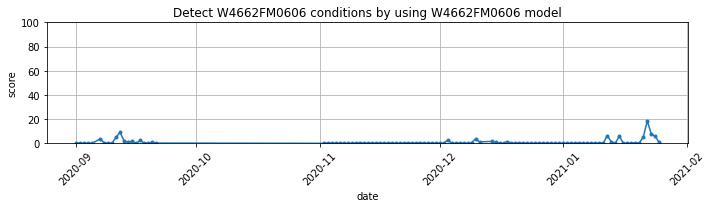

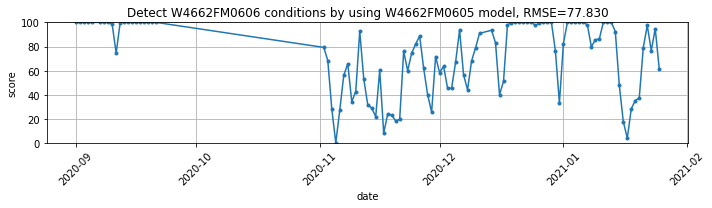

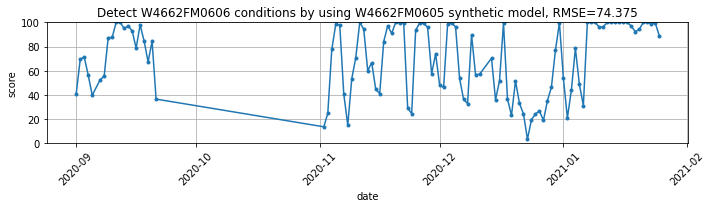

In [30]:

da_rmse = mean_squared_error(target_score_da, target_score, squared=False)
cv_rmse = mean_squared_error(target_score_cv, target_score, squared=False)



plot_score (target_score, target_date, 'Detect ' + tag_dict['target'] +' conditions by using '+ tag_dict['target'] +' model')

plot_score (target_score_cv, 
            target_date_cv, 
            'Detect ' + tag_dict['target'] +' conditions by using '+ tag_dict['source'] +' model, RMSE='+ "{:.3f}".format(cv_rmse))

plot_score (target_score_da, 
            target_date_da, 
            'Detect ' + tag_dict['target'] +' conditions by using '+ tag_dict['source'] +' synthetic model, RMSE=' + "{:.3f}".format(da_rmse))

## Check Synthetic Data

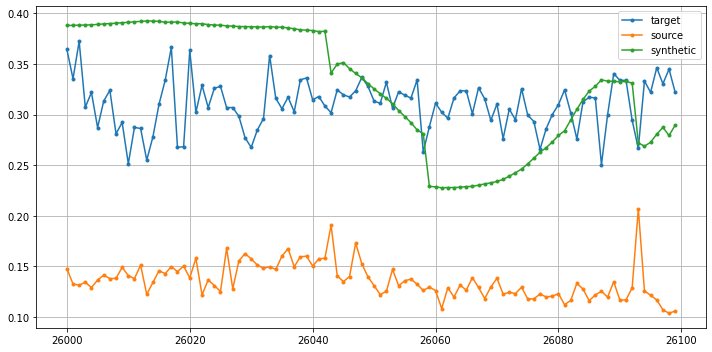

In [31]:

feature_index = 206
duration = 26000
interval = 100
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(range(duration, duration+interval), X_target[feature_index].head(duration).tail(interval), label='target', marker='.')
ax.plot(range(duration, duration+interval), X_source[feature_index].head(duration).tail(interval), label='source', marker='.')
ax.plot(range(duration, duration+interval), synthetic_pd[feature_index].head(duration).tail(interval), label='synthetic', marker='.')

ax.legend()
ax.grid(True)
plt.tight_layout()

#plt.savefig('distribution.png', dpi=300)
plt.show()

## PCA

In [32]:
from sklearn.decomposition import PCA

pca_scale = PCA(n_components=2)
pca_scale = pca_scale.fit(X_source)

X_source_dr = pca_scale.transform(X_source)
x_min, x_max = X_source_dr.min(0), X_source_dr.max(0)
X_norm = (X_source_dr-x_min) / (x_max-x_min)  #Normalize
X_source_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

X_target_dr = pca_scale.transform(X_target)
x_min, x_max = X_target_dr.min(0), X_target_dr.max(0)
X_norm = (X_target_dr-x_min) / (x_max-x_min)  #Normalize
X_target_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

X_decoder_dr = pca_scale.transform(synthetic_pd)
x_min, x_max = X_decoder_dr.min(0), X_decoder_dr.max(0)
X_norm = (X_decoder_dr-x_min) / (x_max-x_min)  #Normalize
X_decode_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

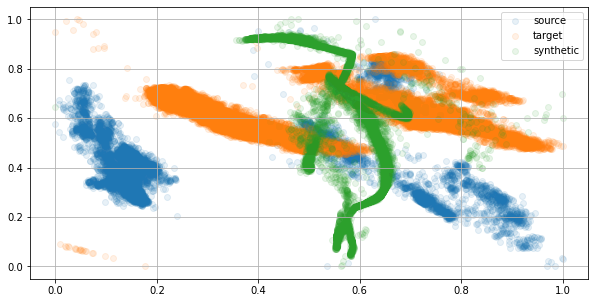

In [33]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(X_source_df['dim1'], X_source_df['dim2'], alpha=0.1, label='source')
ax.scatter(X_target_df['dim1'], X_target_df['dim2'], alpha=0.1, label='target')
ax.scatter(X_decode_df['dim1'], X_decode_df['dim2'], alpha=0.1, label='synthetic')

ax.legend()
ax.grid(True)

#plt.ylim(0, 1)
#plt.xlim(0, 1)
plt.savefig('distribution.png', dpi=300)
plt.show()